## Estimation of carbon emission for transfomer based large language models

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
vocab_size = 51200
seq_length = 2048

In [74]:
scale_data = pd.read_csv('scaling_data.csv')
scale_data['data_model_size'] = (scale_data['#gpus']/(scale_data['tensor_model_size']*scale_data['pipeline_model_size'])).astype(int)

In [77]:
scale_data['#calc_parameters'] = 12*scale_data['number_of_layers']*(scale_data['hidden_size']**2) * (
    1 + (13/(12*scale_data['hidden_size'])) + 
    ((vocab_size + seq_length)/(12*scale_data['number_of_layers']*scale_data['hidden_size']))
)

In [128]:
intra_node = scale_data[scale_data['#parameters'] < 20]
inter_node = scale_data[scale_data['#parameters'] > 20]
pipe_data = scale_data[scale_data['tensor_model_size'] >= 8]
gpu_data = scale_data[scale_data['#parameters'] > 70]
batch_data = scale_data[(scale_data['pipeline_model_size'] >= 1) & (scale_data['tensor_model_size'] >= 8)]

In [82]:
all_parameters = scale_data['#parameters']
all_throughput = scale_data['achieved_teraFLOPs_per_gpu']

intra_parameters = intra_node['#parameters']
intra_throughput = intra_node['achieved_teraFLOPs_per_gpu']
inter_parameters = inter_node['#parameters']
inter_throughput = inter_node['achieved_teraFLOPs_per_gpu']
tensor_size = intra_node['tensor_model_size']

pipe_throughput = pipe_data['achieved_teraFLOPs_per_gpu']
pipe_size = pipe_data['pipeline_model_size']
data_size = pipe_data['data_model_size']

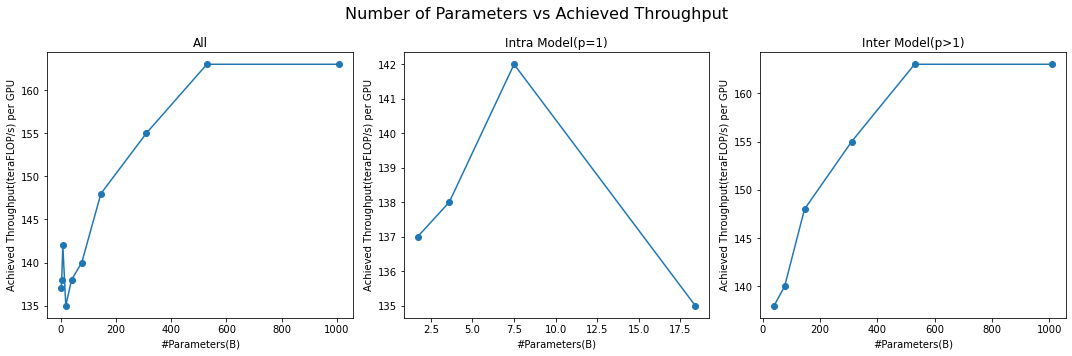

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axes[0].plot(all_parameters, throughput, marker='o')
axes[0].set_xlabel('#Parameters(B)')
axes[0].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[0].set_title('All')

axes[1].plot(intra_parameters, intra_throughput, marker='o')
axes[1].set_xlabel('#Parameters(B)')
axes[1].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[1].set_title('Intra Model(p=1)')

axes[2].plot(inter_parameters, inter_throughput, marker='o')
axes[2].set_xlabel('#Parameters(B)')
axes[2].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[2].set_title('Inter Model(p>1)')

fig.suptitle('Number of Parameters vs Achieved Throughput', fontsize=16)
plt.tight_layout()

plt.show()
plt.close()

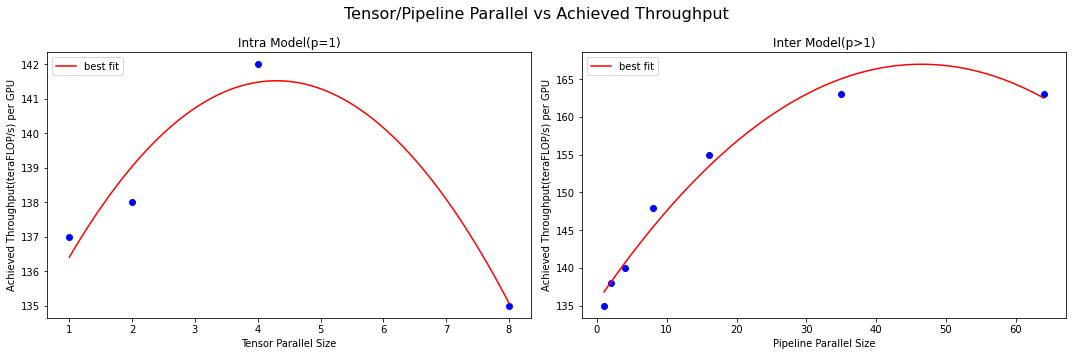

In [86]:
#polynomial(2d) regression - tensor parallel
coeff_tensor = np.polyfit(tensor_size, intra_throughput, 2)
func_tensor = np.poly1d(coeff_tensor)
x_tensor = np.linspace(min(tensor_size), max(tensor_size), 100)
y_tensor = func_tensor(x_tensor)

#polynomial(2d) regression - pipe parallel
coeff_pipe = np.polyfit(pipe_size, pipe_throughput, 2)
func_pipe = np.poly1d(coeff_pipe)
x_pipe = np.linspace(min(pipe_size), max(pipe_size), 100)
y_pipe = func_pipe(x_pipe)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].scatter(tensor_size, intra_throughput, marker='o', color='blue')
axes[0].plot(x_tensor, y_tensor, color='red', label='best fit')
axes[0].set_xlabel('Tensor Parallel Size')
axes[0].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[0].set_title('Intra Model(p=1)')
axes[0].legend(loc='upper left')

axes[1].scatter(pipe_size, pipe_throughput, marker='o', color='blue')
axes[1].plot(x_pipe, y_pipe, color='red', label='best fit')
axes[1].set_xlabel('Pipeline Parallel Size')
axes[1].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[1].set_title('Inter Model(p>1)')
axes[1].legend(loc='upper left')

fig.suptitle('Tensor/Pipeline Parallel vs Achieved Throughput', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()


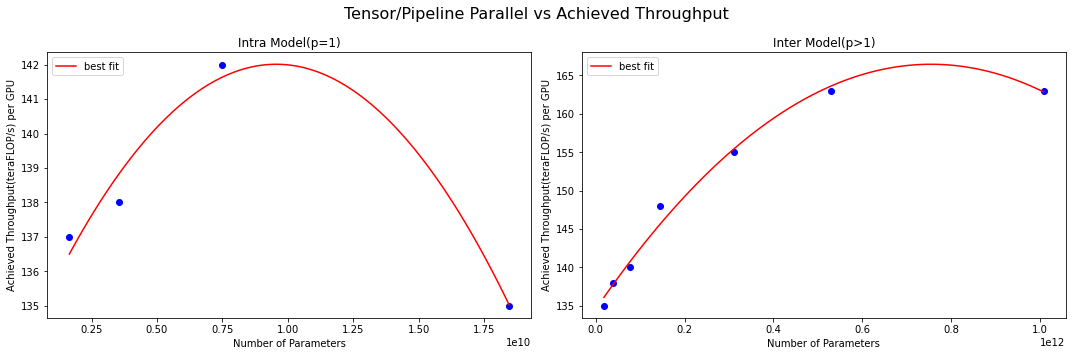

In [103]:
#polynomial(2d) regression - tensor parallel
range_tensor = intra_node['#calc_parameters']
coeff_tensor = np.polyfit(range_tensor, intra_throughput, 2)
func_tensor = np.poly1d(coeff_tensor)
x_tensor = np.linspace(min(range_tensor), max(range_tensor), 100)
y_tensor = func_tensor(x_tensor)

#polynomial(2d) regression - pipe parallel
range_tensor1 = pipe_data['#calc_parameters']
coeff_pipe = np.polyfit(range_tensor1, pipe_throughput, 2)
func_pipe = np.poly1d(coeff_pipe)
x_pipe = np.linspace(min(range_tensor1), max(range_tensor1), 100)
y_pipe = func_pipe(x_pipe)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].scatter(range_tensor, intra_throughput, marker='o', color='blue')
axes[0].plot(x_tensor, y_tensor, color='red', label='best fit')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[0].set_title('Intra Model(p=1)')
axes[0].legend(loc='upper left')

axes[1].scatter(range_tensor1, pipe_throughput, marker='o', color='blue')
axes[1].plot(x_pipe, y_pipe, color='red', label='best fit')
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Achieved Throughput(teraFLOP/s) per GPU')
axes[1].set_title('Inter Model(p>1)')
axes[1].legend(loc='upper left')

fig.suptitle('Tensor/Pipeline Parallel vs Achieved Throughput', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()


### Best Fit Coefficients 
$y = ax^2 + bx + c$ 

Tesnor Parallel: \
$a=-0.47, b=4.04, c=132.83$

Pipe Parallel: \
$a=-0.0146, b=1.355, c=135.48$

In [87]:
coeff_tensor, coeff_pipe

(array([ -0.47043011,   4.04354839, 132.83333333]),
 array([-1.45731509e-02,  1.35525734e+00,  1.35475675e+02]))

### Variation of batch size with number of parameters

* If #Parameters < 18 then batch_size = 512
* If #Parameters > 18 then batch_size = 512

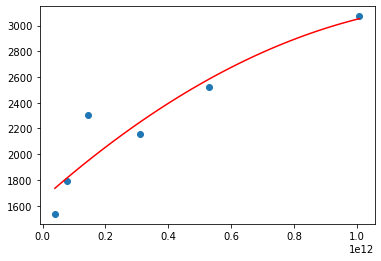

In [88]:
coeff_batch = np.polyfit(inter_node['#calc_parameters'], inter_node['batch_size'], 2)
func_batch = np.poly1d(coeff_batch)
x_batch = np.linspace(min(inter_node['#calc_parameters']), max(inter_node['#calc_parameters']), 100)
y_batch = func_batch(x_batch)
plt.scatter(inter_node['#calc_parameters'], inter_node['batch_size'], marker = 'o')
plt.plot(x_batch, y_batch, color='red', label='best fit')

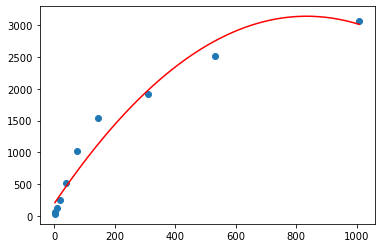

In [67]:
coeff_gpu = np.polyfit(scale_data['#parameters'], scale_data['#gpus'], 2)
func_gpu = np.poly1d(coeff_gpu)
x_gpu = np.linspace(min(scale_data['#parameters']), max(scale_data['#parameters']), 100)
y_gpu = func_gpu(x_gpu)
plt.scatter(scale_data['#parameters'], scale_data['#gpus'], marker = 'o')
plt.plot(x_gpu, y_gpu, color='red', label='best fit')

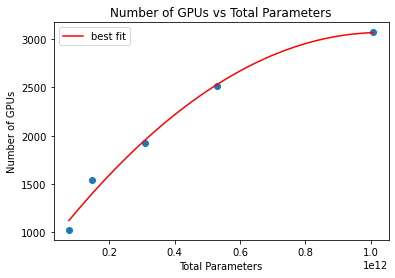

In [173]:
#func gpus
#number of gpus is a multiple of intra_node_size
range_gpu = gpu_data['#calc_parameters']
coeff_gpu = np.polyfit(range_gpu, gpu_data['#gpus'], 2)
func_gpu = np.poly1d(coeff_gpu)
x_gpu = np.linspace(min(range_gpu), max(range_gpu), 100)
y_gpu = func_gpu(x_gpu)
plt.scatter(gpu_data['#calc_parameters'], gpu_data['#gpus'], marker = 'o')
plt.plot(x_gpu, y_gpu, color='red', label='best fit')
plt.xlabel('Total Parameters')
plt.ylabel('Number of GPUs')
plt.title('Number of GPUs vs Total Parameters')
plt.legend()
plt.show()
plt.close()

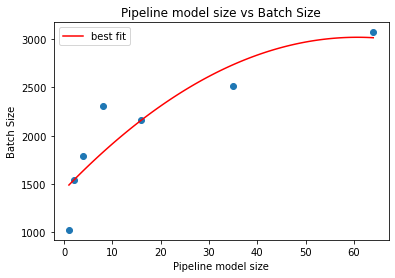

In [174]:
#func batch
#batch size is a multiple of intra_node_size
range_batch = batch_data['pipeline_model_size']
coeff_batch = np.polyfit(range_batch, batch_data['batch_size'], 2)
func_batch = np.poly1d(coeff_batch)
x_batch = np.linspace(min(range_batch), max(range_batch), 100)
y_batch = func_batch(x_batch)
plt.scatter(batch_data['pipeline_model_size'], batch_data['batch_size'], marker = 'o')
plt.plot(x_batch, y_batch, color='red', label='best fit')
plt.xlabel('Pipeline model size')
plt.ylabel('Batch Size')
plt.title('Pipeline model size vs Batch Size')
plt.legend()
plt.show()
plt.close()

In [117]:
V = 51200
s = 2048
h = 2304
a = 24
l = 24
intra_node_size = 8
gpu_cap = 2.4
tokens = 300000000000
parameters = 12*l*(h**2)*(1 + (13/(12*h)) + ((V+s)/(12*l*h)))

In [145]:
1024*2.4

2457.6

In [154]:
parameters = 175000000000
parameters_b = parameters/1000000000
parameters, parameters_b

(175000000000, 175.0)

In [2]:
175/2.4

72.91666666666667

In [140]:
num_gpus = np.ceil(parameters_b/gpu_cap)
num_gpus

73.0

In [155]:
if parameters_b < (intra_node_size*gpu_cap):
    p_size = 1
    t_size = int(np.ceil(parameters_b/gpu_cap))
else:
    t_size = intra_node_size
    p_size = int(np.ceil(parameters_b/(intra_node_size*gpu_cap)))

In [156]:
t_size, p_size

(8, 10)

In [157]:
#intra model condition
if (t_size <= intra_node_size and p_size == 1):
    est_thru = func_tensor(parameters)
# inter model     
else:
    est_thru = func_pipe(parameters)

est_thru

147.62553627125612

In [158]:
# data parallel size
if parameters_b < 100:
    d_size = 4*intra_node_size
    num_gpus = p_size*t_size*d_size
else:
    model_size = t_size*p_size
    num_gpus = np.round(func_gpu(parameters)/model_size)*model_size
    d_size = num_gpus/(t_size*p_size)
d_size, num_gpus    

(19.0, 1520.0)

In [159]:
#estimated batch size
if p_size == 1:
    batch_size = 512
else:
    batch_size = np.round(func_batch(p_size)/8)*8
    if batch_size < num_gpus:
        batch_size = num_gpus
batch_size, num_gpus

(1912.0, 1520.0)

In [170]:
#estimate training time
time_train = (8*tokens*parameters)/(num_gpus*est_thru*(10**12))
time_train_days = np.ceil(time_train/(24*60*60))
time_train_hours = time_train_days * 24
time_train_days, time_train_hours

(22.0, 528.0)

In [169]:
#estimate co2 emission
power_consume = 0.25
time = time_train_days*24
region_co2 = 0.56
co2 = power_consume * time * region_co2
co2

73.92